### Evaluate the conversation flows of twitter respond-trees

This notebook is a documentation on how particulary damaging tweets might be filtered
out by looking at them from a sentiment delta perspective.

First we download the data from our database.

In [9]:
import pandas as pd

from util.sql_switch import get_query_native

# Create your connection.


df = get_query_native(
    "SELECT id, conversation_id, sentiment,sentiment_value,created_at, tn_level, tn_order FROM delab_tweet where sentiment = 'positive' or sentiment = 'negative'")

df.head(3)

using postgres


,id,conversation_id,sentiment,sentiment_value,created_at,tn_level,tn_order
0,7872,1451543608398651395,negative,-2.161735,2021-10-22 13:49:55+00:00,2,3091
1,9727,1451256052205379596,negative,-3.141176,2021-10-22 10:43:06+00:00,4,4945
2,9721,1451256052205379596,positive,15.692247,2021-10-22 21:02:52+00:00,3,4939


The conversation_id corresponds to the twitter field with the same name.  The sentiment values
are computed using a neural net and trax, using twitter samples as training data.

Depending on the state of the database different length of conversations are downloaded present:

In [10]:
df['conversation_id'].value_counts()



1450956635690704899    797
1451230354497495044    773
1452436776916762629    490
1451362578060431365    245
1449411492021825541    239
1450672167134408705    236
1451256052205379596    182
1451251605026787340    176
1451543608398651395    140
1452459721248620546    133
1452360506011013120    111
1451380440942751755    101
1452612221834600448     71
1450428916032749577     70
1451526982697689113     50
1452509182670909447     40
1451378416205242372     31
1422614889827225603     25
1452425962897948675     21
1451470058849554435     19
1451404584925085703     12
1452642163947409419     10
1450525128404705283      1
1231                     1
Name: conversation_id, dtype: int64

Next we group the data by the conversation_id.



In [11]:
example_id = df.at[0, 'conversation_id']  # select the first conversation as an example
# df_subset = df[~df.sentiment_value.isnull()]
df_subset = df[df.conversation_id == example_id]
df_subset = df_subset.sort_values(by=['created_at'])
df_subset.reset_index(drop=True, inplace=True)
df_subset.head(5)

,id,conversation_id,sentiment,sentiment_value,created_at,tn_level,tn_order
0,7780,1451543608398651395,negative,-3.239686,2021-10-22 13:38:59+00:00,1,2999
1,7960,1451543608398651395,positive,15.765659,2021-10-22 13:39:35+00:00,2,3179
2,7959,1451543608398651395,positive,1.217691,2021-10-22 13:40:30+00:00,2,3178
3,7958,1451543608398651395,negative,-3.650880,2021-10-22 13:40:31+00:00,2,3177
4,7957,1451543608398651395,positive,22.665104,2021-10-22 13:40:58+00:00,2,3176


Now we are using rolling mean to get a better idea of significant changes.
The rolling mean looks at a windows n (here 3) tweets and smoothens the curve accordingly:
https://en.wikipedia.org/wiki/Moving_average

In [12]:
rolling_column = df_subset['sentiment_value'].rolling(3).mean()
df_subset = df_subset.assign(rolling_sentiment=rolling_column)
df_subset.head(5)

,id,conversation_id,sentiment,sentiment_value,created_at,tn_level,tn_order,rolling_sentiment
0,7780,1451543608398651395,negative,-3.239686,2021-10-22 13:38:59+00:00,1,2999,NaN
1,7960,1451543608398651395,positive,15.765659,2021-10-22 13:39:35+00:00,2,3179,NaN
2,7959,1451543608398651395,positive,1.217691,2021-10-22 13:40:30+00:00,2,3178,4.581221
3,7958,1451543608398651395,negative,-3.650880,2021-10-22 13:40:31+00:00,2,3177,4.444157
4,7957,1451543608398651395,positive,22.665104,2021-10-22 13:40:58+00:00,2,3176,6.743972


### Plotting the rolling average to highlight extreme posts

We use the index as x_axis and the rolling average of the sentiment value as y.
This is the graph that is displayed in the proof-of-concept website.

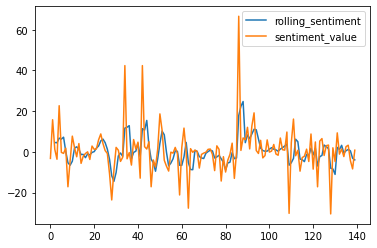

In [13]:
plot = df_subset.plot(y=['rolling_sentiment', 'sentiment_value'], use_index=True)
plot.get_figure().savefig('rolling_sentiment.png')

In order to find out candidates with the highest impact we can look at the differentials.

$$ candidate_{conv} = \arg\max_{x\in n}(x_{n+1}-x_n) \land |conv| = n  $$

We can already see the issue that very early tweets or the last ones are not defined by this.

In [14]:
diffs = df_subset.rolling_sentiment.diff().abs()
#df_subset["diffs"]=diffs
df_subset = df_subset.assign(rolling_deltas=diffs)
df_subset.head(10)

,id,conversation_id,sentiment,sentiment_value,created_at,tn_level,tn_order,rolling_sentiment,rolling_deltas
0,7780,1451543608398651395,negative,-3.239686,2021-10-22 13:38:59+00:00,1,2999,NaN,NaN
1,7960,1451543608398651395,positive,15.765659,2021-10-22 13:39:35+00:00,2,3179,NaN,NaN
2,7959,1451543608398651395,positive,1.217691,2021-10-22 13:40:30+00:00,2,3178,4.581221,NaN
3,7958,1451543608398651395,negative,-3.650880,2021-10-22 13:40:31+00:00,2,3177,4.444157,0.137065
4,7957,1451543608398651395,positive,22.665104,2021-10-22 13:40:58+00:00,2,3176,6.743972,2.299815
5,7956,1451543608398651395,negative,-0.285687,2021-10-22 13:41:09+00:00,2,3175,6.242846,0.501126
6,7944,1451543608398651395,negative,-0.780391,2021-10-22 13:45:02+00:00,2,3163,7.199675,0.956830
7,7943,1451543608398651395,positive,1.813662,2021-10-22 13:45:10+00:00,2,3162,0.249195,6.950481
8,7942,1451543608398651395,negative,-17.170437,2021-10-22 13:45:23+00:00,2,3161,-5.379055,5.628250
9,7941,1451543608398651395,negative,-4.399145,2021-10-22 13:45:42+00:00,2,3160,-6.585307,1.206251


Next we are printing the candidate tweet that changed the dicussion the most based on the sentiment predictions:

In [15]:
pd.options.display.max_colwidth = 500  # so we can see the full tweet
ix_of_candidate = df_subset.rolling_deltas.argmax() - 1
id_of_candidate = df_subset.loc[ix_of_candidate, "id"]

df_candidate = get_query_native("SELECT id, text FROM delab_tweet where id='{}'".format(id_of_candidate))

df_candidate = df_candidate.assign(sentiment_delta=df_subset.iloc[ix_of_candidate + 1].rolling_deltas)
#print(df_candidate.text)
df_candidate.head()


using postgres


,id,text,sentiment_delta
0,7821,@ChuckCallesto @AltheaOrvis Lord told me in October and November of 2019 that in 2020 a spiritual and natural war would begin with a battle field like we have never seen before and never will again it will continue to encrees every year until LORD coming 🙏.,20.791247


### Questions that arise from the data:
- Does the tree level (is a tweet answer of an answer of an answer lvl3 ...) matter?
- The rolling average leaves NaN for the first n tweets, is that a problem?
- How long does the conversation have to be in order for the delta to be significant?
- Is the underlying sentiment analysis predictive enough (and accurate enough)?
- The rolling average might be biased by the last tweet (as it makes up 100% of the average in the end)
- The rolling average might be substituted for a method more suited for lower number of data points